In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,LeakyReLU,BatchNormalization
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Conv2D, Conv2DTranspose,DepthwiseConv2D
from keras.layers import MaxPooling2D, GlobalMaxPool2D, Concatenate
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping

2024-04-03 00:34:38.787498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-03 00:34:38.787586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-03 00:34:38.930451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Set some parameters
im_width = 256
im_height = 256
ids1 = next(os.walk("/kaggle/input/brain-tumor-segmentation/images"))[2]
X = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(ids1), total=len(ids1)):
    # Load images
    img = load_img("/kaggle/input/brain-tumor-segmentation/images/" + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (256, 256, 1), mode='constant', preserve_range=True)
    # Load masks
    mask = img_to_array(load_img("/kaggle/input/brain-tumor-segmentation/masks/" + id_, grayscale=True))
    mask = resize(mask, (256, 256, 1), mode='constant', preserve_range=True)
    # Save images
    X[n] = x_img / 255.0
    y[n] = mask / 255.0

  0%|          | 0/3064 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
100%|██████████| 3064/3064 [01:47<00:00, 28.51it/s]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,shuffle=True)

In [10]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [11]:
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function


In [12]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    #print(s4.shape , p4.shape)
    s5, p5 = encoder_block(p4, 1024)
    #print(s5.shape , p5.shape)
    
    b1 = conv_block(p5, 2048)


    d1 = decoder_block(b1, s5, 1024)
    d2 = decoder_block(d1, s4, 512)
    d3 = decoder_block(d2, s3, 256)
    d4 = decoder_block(d3, s2, 128)
    d5 = decoder_block(d4, s1, 64)
    #----------------------------------#
    print("\n")
    print(b1.shape , s5.shape)
    print(d1.shape , s4.shape)
    print(d2.shape , s3.shape)
    print(d3.shape , s2.shape)
    print(d4.shape , s1.shape)
    print("\n")
    print(d5.shape,"\n")
    #----------------------------------#

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d5)
    print(outputs.shape)
    model = Model(inputs, outputs, name="U-NET")
    return model

model = unet((256,256,1))
model.summary()



(None, 8, 8, 2048) (None, 16, 16, 1024)
(None, 16, 16, 1024) (None, 32, 32, 512)
(None, 32, 32, 512) (None, 64, 64, 256)
(None, 64, 64, 256) (None, 128, 128, 128)
(None, 128, 128, 128) (None, 256, 256, 64)


(None, 256, 256, 64) 

(None, 256, 256, 1)
Model: "U-NET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 256, 256, 64)         640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 256, 256, 64)         256       ['conv2d_23[0][0]']           
 tchNormalization)                     

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

In [14]:
model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])
history = model.fit(X_train, y_train, batch_size=16,callbacks=[early_stopping],epochs=20)

Epoch 1/20


I0000 00:00:1712104688.662494     100 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


154/154 [==============================] - 122s 530ms/step - loss: -0.1597 - jacard_coef: 0.1598
Epoch 2/20
154/154 [==============================] - 76s 492ms/step - loss: -0.2903 - jacard_coef: 0.2898
Epoch 3/20
154/154 [==============================] - 76s 492ms/step - loss: -0.2991 - jacard_coef: 0.2984
Epoch 4/20
154/154 [==============================] - 76s 492ms/step - loss: -0.3549 - jacard_coef: 0.3549
Epoch 5/20
154/154 [==============================] - 76s 492ms/step - loss: -0.3758 - jacard_coef: 0.3763
Epoch 6/20
154/154 [==============================] - 76s 492ms/step - loss: -0.4231 - jacard_coef: 0.4225
Epoch 7/20
154/154 [==============================] - 76s 492ms/step - loss: -0.4281 - jacard_coef: 0.4291
Epoch 8/20
154/154 [==============================] - 76s 492ms/step - loss: -0.4832 - jacard_coef: 0.4826
Epoch 9/20
154/154 [==============================] - 76s 492ms/step - loss: -0.4985 - jacard_coef: 0.4970
Epoch 10/20
154/154 [==========================

In [15]:

model.save_weights('/kaggle/working/BrainTumor.h5')
model.load_weights('/kaggle/working/BrainTumor.h5')


In [16]:
# Evaluate the model on test data
loss, IOU = model.evaluate(X_test, y_test)
print("Test Accuracy, IOU:", IOU)

# Predict masks on test data
y_pred = model.predict(X_test)

# Convert predicted masks to binary values
y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test = (y_test > 0.5).astype(np.uint8)



20/20 [==============================] - 30s 488ms/step - loss: -0.4606 - jacard_coef: 0.4682
Test Accuracy, IOU: 0.4681766927242279
20/20 [==============================] - 6s 287ms/step


In [17]:
X_test.shape

(613, 256, 256, 1)

In [18]:
import random
rand_num = random.randint(0,613)
print(rand_num)

247


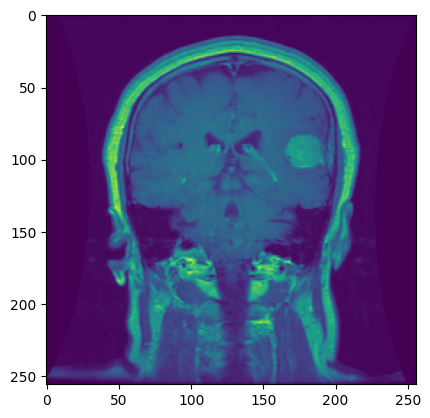

In [19]:
img_demo = X_test[rand_num]
plt.imshow(img_demo)

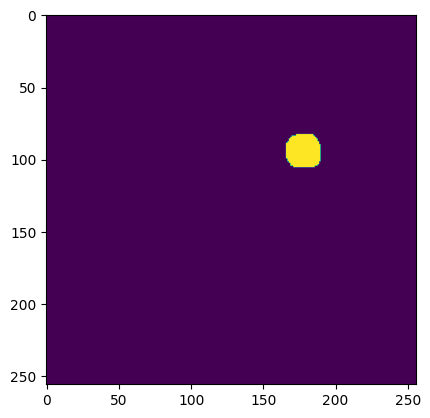

In [20]:
seg_demo = y_test[rand_num]
plt.imshow(seg_demo)

In [21]:
def dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    dice = (2.0 * intersection) / (union + intersection)
    return dice
dice_scores = []
for i in range(len(X_test)):
    dice = dice_coefficient(y_test[i], y_pred_binary[i])
    dice_scores.append(dice)
average_dice = np.mean(dice_scores)
print("Average Dice Score:", average_dice)


Average Dice Score: 0.41574301970894084
